## Подключим библиотеки и подгрузим датасет



In [1]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [65]:
test= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic_data/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic_data/train.csv')
gender_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic_data/gender_submission.csv')

In [66]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


Объединим выборки train и test, чтобы в дальнейшем самостоятельно разделять выборку, например, для кросс-валидации, также будет удобно проводить препроцессинг данных сразу с генеральной совокупностью 

In [3]:
test['Survived'] = gender_submission['Survived']
passengers = train.copy()

In [4]:
labels = passengers.columns.tolist()
labels = labels[0:1] + labels[2:] + labels[1:2]

passengers = passengers[labels]
passengers = passengers.append(test, ignore_index=True)

## Посмотрим на данные

### "Первыми спасаются женщины, дети и старики"

В данном разделе проверим эту гипотезу, найдём неоднородности в данных и просто ознакомимся с этими данными




In [5]:
passengers.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [6]:
print('Embarked unique: ', passengers['Embarked'].unique())
print('Sex unique: ', passengers['Sex'].unique())
print('Pclass unique: ', passengers['Pclass'].unique())
print('Parch unique: ', passengers['Parch'].unique())
print('SibSp unique: ', passengers['SibSp'].unique())

Embarked unique:  ['S' 'C' 'Q' nan]
Sex unique:  ['male' 'female']
Pclass unique:  [3 1 2]
Parch unique:  [0 1 2 5 3 4 6 9]
SibSp unique:  [1 0 3 4 2 5 8]


In [7]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Survived     1309 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [8]:
print('Age NaNs: ', len(passengers[passengers['Age'].isna()])/len(passengers) * 100, '%')
print('Cabin NaNs: ', len(passengers[passengers['Cabin'].isna()])/len(passengers) * 100, '%')

Age NaNs:  20.091673032849503 %
Cabin NaNs:  77.46371275783041 %


Больше всего NaN значений в фичах 'Cabin', 'Age'

In [9]:
passengers.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479,0.377387
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668,0.484918
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


Выжило 37.7% пассажиров, средний возраст пассажира 29.8, стандартное отклонение 14.4, т.е. рассматривать пассажиров у которых возраст больше 29.8 + 14.4 или пассажиров возрастом меньше 29.8 - 14.4 не имеет смысла, так как их меньшенство и на результат они оказывают небольшое влияние. То есть гипотеза о том, что выживаемость зависит от возраста не отражает действительность 

In [10]:
women = passengers[passengers['Sex'] == 'female']
sum(women['Survived'])/len(women)

0.8261802575107297

82.6% женщин выжило

In [11]:
men = passengers[passengers['Sex'] == 'male']
sum(men['Survived'])/len(men)

0.12930011862396204

12.9% мужчин выжило

In [12]:
elderly = passengers[passengers['Age'] >= 44]
sum(elderly['Survived'])/len(elderly)

0.4032258064516129

In [13]:
young = passengers[passengers['Age'] < 18]
sum(young['Survived'])/len(young)

0.5064935064935064

In [14]:
elderly_women = women[women['Age'] >= 44]
sum(elderly_women['Survived'])/len(elderly_women)

0.8823529411764706

In [15]:
elderly_men = men[men['Age'] >= 44]
sum(elderly_men['Survived'])/len(elderly_men)

0.1271186440677966

In [16]:
children_female = women[(women['Age'] < 18)]
sum(children_female['Survived'])/len(children_female)

0.7638888888888888

In [17]:
children_male = men[men['Age'] <= 18]
sum(children_male['Survived'])/len(children_male)

0.2376237623762376

По полученным данным нельзя с уверенностью сказать как возраст влияет на выживаемость, остаётся только детальнее рассмотреть данный признак

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

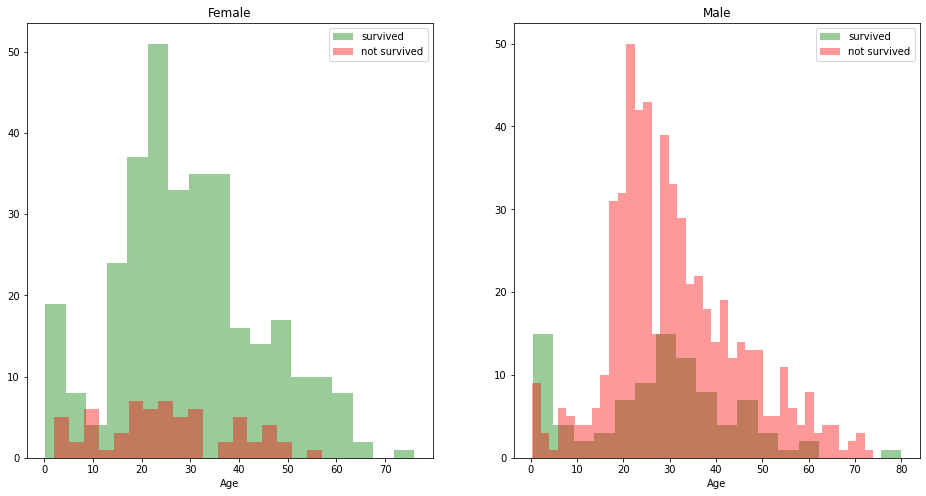

In [19]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False, color="green")
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=18, label = not_survived, ax = axes[0], kde =False, color="red")
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False, color="green")
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color="red")
ax.legend()
_ = ax.set_title('Male');

Гипотеза с тем, что должны были спастись старики и дети не подтвердилась.

На графике для Female видно, что самое большое количество выживших в районе 20+ лет, также есть всплеск около 0+ лет. Ещё стоит отметить, что частично изначальная гипотеза работает, так как нет смертей среди детей 0+ и стариков 60+ 

На графике для Male можно наблюдать повышенную смертность в районе 20+ лет. Всплеск в районе 0+ лет подобен как на графике для Female.

### Проверим признаки 'Class', 'Embarked' и 'Fare'
Для начала разберёмся с признаком 'Class' и 'Embarked'


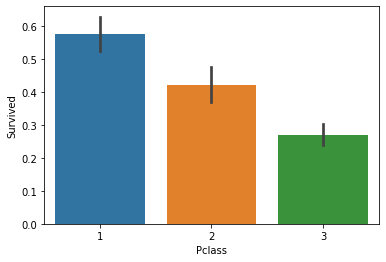

In [20]:
sns.barplot(data=passengers, x='Pclass', y='Survived')

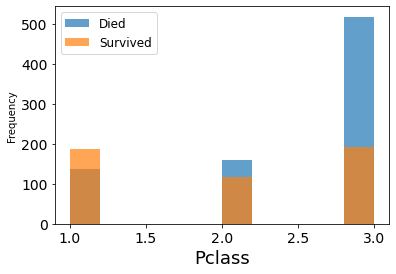

In [21]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

plt.figure()
fig = passengers.groupby('Survived')['Pclass'].plot.hist(histtype= 'bar', alpha = 0.7)
plt.legend(('Died','Survived'), fontsize = 12)
plt.xlabel('Pclass', fontsize = 18)
plt.show()

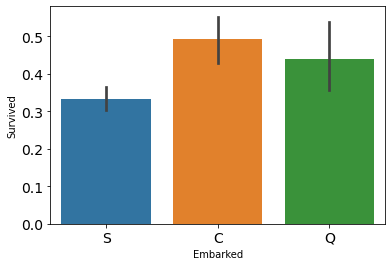

In [22]:
sns.barplot(data=passengers, x='Embarked', y='Survived')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Fare_Survived')

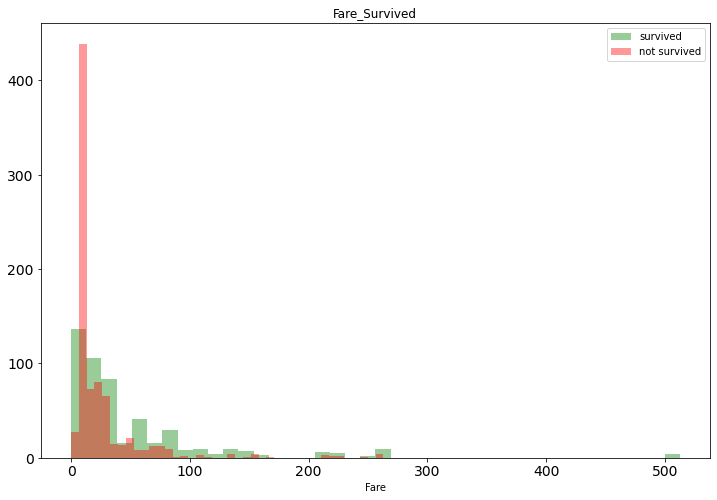

In [23]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(figsize=(12, 8))
ax = sns.distplot(passengers[passengers['Survived']==1].Fare.dropna(), bins=40, label = survived, kde =False, color="green")
ax = sns.distplot(passengers[passengers['Survived']==0].Fare.dropna(), bins=40, label = not_survived, kde =False, color="red")
ax.legend()
ax.set_title('Fare_Survived')

## Сделаем препроцессинг данных:



### 0.   Почистим признаки
которые по мнению автора не могли повлиять на выживаемость пассажира и которые тяжкло интерпретировать (Name| PassengerID|  Ticket| Cabin| Age)

'Cabin' - возможно данный признак мог повлиять на то, выживет ли пассажир, но непонятно как преобразовать эти данные.

Далее создадим ещё копию дата сета, так как данный (с категориальными признаками без One-hot encoding) будем использовать с CatBoost

In [24]:
passengers_for_cat_boost = passengers.copy()
passengers_for_cat_boost = passengers_for_cat_boost.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'Age'], axis = 1)
passengers_dropped = passengers_for_cat_boost
passengers_for_cat_boost.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Survived
0,3,male,1,0,7.2500,S,0
1,1,female,1,0,71.2833,C,1
2,3,female,0,0,7.9250,S,1
3,1,female,1,0,53.1000,S,1
4,3,male,0,0,8.0500,S,0


### 1. Произведём кодирование столбца 'Sex'  

Взаимооднозначное соответствие

1.   List item
2.   List item


$$ male \leftrightarrow 0 $$ 
$$ female \leftrightarrow 1 $$


In [25]:
passengers_dropped = passengers_dropped.replace({'male': 0, 'female': 1})
passengers_dropped

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Survived
0,3,0,1,0,7.2500,S,0
1,1,1,1,0,71.2833,C,1
2,3,1,0,0,7.9250,S,1
3,1,1,1,0,53.1000,S,1
4,3,0,0,0,8.0500,S,0
...,...,...,...,...,...,...,...
1304,3,0,0,0,8.0500,S,0
1305,1,1,0,0,108.9000,C,1
1306,3,0,0,0,7.2500,S,0
1307,3,0,0,0,8.0500,S,0


### 2. Произведём кодирование столбца 'Embarked' 



In [26]:
dummy_features = pd.get_dummies(passengers_dropped['Embarked'])
passengers_dropped_encoded = passengers_dropped.drop('Embarked', axis=1)
passengers_dropped_encoded = pd.concat([passengers_dropped_encoded, dummy_features], axis=1)
passengers_dropped_encoded

,Pclass,Sex,SibSp,Parch,Fare,Survived,C,Q,S
0,3,0,1,0,7.2500,0,0,0,1
1,1,1,1,0,71.2833,1,1,0,0
2,3,1,0,0,7.9250,1,0,0,1
3,1,1,1,0,53.1000,1,0,0,1
4,3,0,0,0,8.0500,0,0,0,1
...,...,...,...,...,...,...,...,...,...
1304,3,0,0,0,8.0500,0,0,0,1
1305,1,1,0,0,108.9000,1,1,0,0
1306,3,0,0,0,7.2500,0,0,0,1
1307,3,0,0,0,8.0500,0,0,0,1


### 2. Расправляемся с NaN
Можно просто убрать данные, можно попробовать заполнить средними значениями, либо попробовать предсказать самостоятельно на основании других признаков. 

Будем просто избавляться от данных




In [27]:
passengers_dropped_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Sex       1309 non-null   int64  
 2   SibSp     1309 non-null   int64  
 3   Parch     1309 non-null   int64  
 4   Fare      1308 non-null   float64
 5   Survived  1309 non-null   int64  
 6   C         1309 non-null   uint8  
 7   Q         1309 non-null   uint8  
 8   S         1309 non-null   uint8  
dtypes: float64(1), int64(5), uint8(3)
memory usage: 65.3 KB


In [28]:
passengers_dropped_encoded = passengers_dropped_encoded.dropna(axis=0, how='any')
passengers_dropped_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1308 non-null   int64  
 1   Sex       1308 non-null   int64  
 2   SibSp     1308 non-null   int64  
 3   Parch     1308 non-null   int64  
 4   Fare      1308 non-null   float64
 5   Survived  1308 non-null   int64  
 6   C         1308 non-null   uint8  
 7   Q         1308 non-null   uint8  
 8   S         1308 non-null   uint8  
dtypes: float64(1), int64(5), uint8(3)
memory usage: 75.4 KB


### 3. Проведём разделение и нормализацию данных





Предварительно разделим данные на train и test, чтобы в результате нормализации не было утечки данных из тестовой выборки

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X = passengers_dropped_encoded.drop(['Survived'], axis=1)
y = passengers_dropped_encoded['Survived']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8, random_state=47)

Собственно сама нормализация через стандартное отклонение $$z = \frac{x - \mu}{\sigma}, \text{где $\sigma$ - стандартное отклонение, а  $\mu$ - среднее}$$

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Подберём оптимальную модель


### Попробуем классификаторы kNN, Decision Tree

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve

Также для подбора гиперпараметров напишем функцию, визуализирующую поиск оптимального значения гиперпараметра по сетке

In [33]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, 
                            param_grid=parameters,
                            cv=5, 
                            scoring='f1',
                            n_jobs=-1, 
                            verbose=10)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']

    if draw:
        y_train_predicted = CV_model.predict_proba(X)[:, 1]
        y_test_predicted = CV_model.predict_proba(X_test_scaled)[:, 1]

        train_auc = roc_auc_score(y_train, y_train_predicted)
        test_auc = roc_auc_score(y_test, y_test_predicted)

        plt.figure(figsize=(10,7))
        plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
        plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
        legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
        plt.show()

        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        # plt.fill_between(grid, means - 2 * error, means + 2 * error, 
        #                  color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

In [34]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth', 'n_estimators']
grids = [np.array(np.linspace(4, 50, 8), dtype='int'), np.arange(3, 80, 8)]
param_scales = ['ordinary', 'ordinary']

Сравним результаты, если мы будем использовать данные с нормализацией и без

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1923s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0706s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1265s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.4s finished


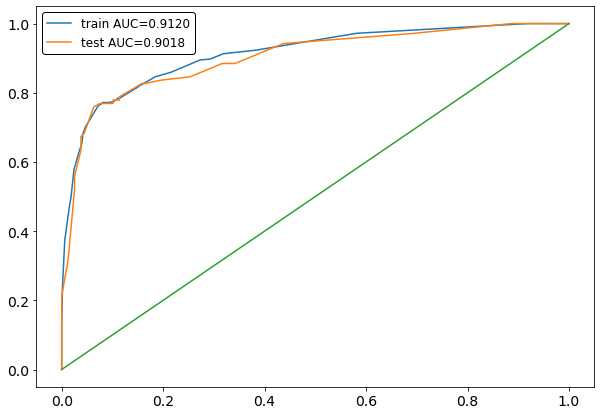

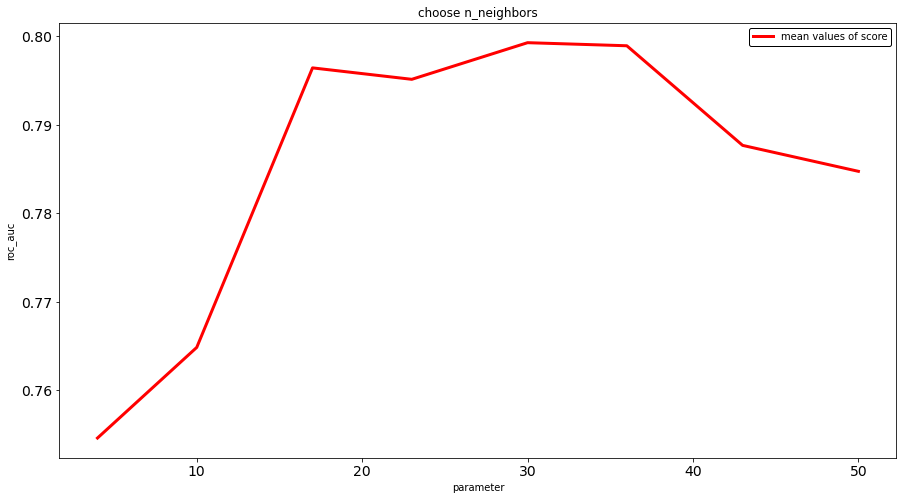

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0186s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0198s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0299s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0500s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


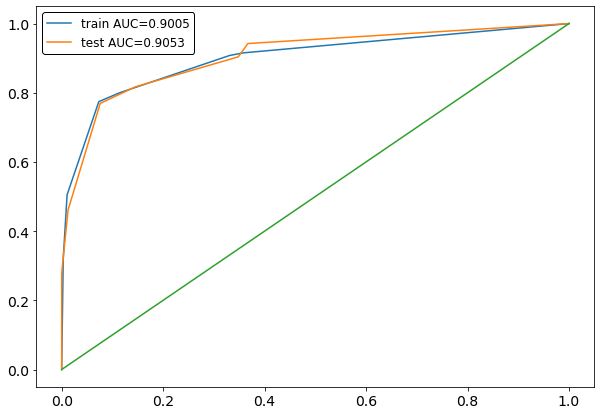

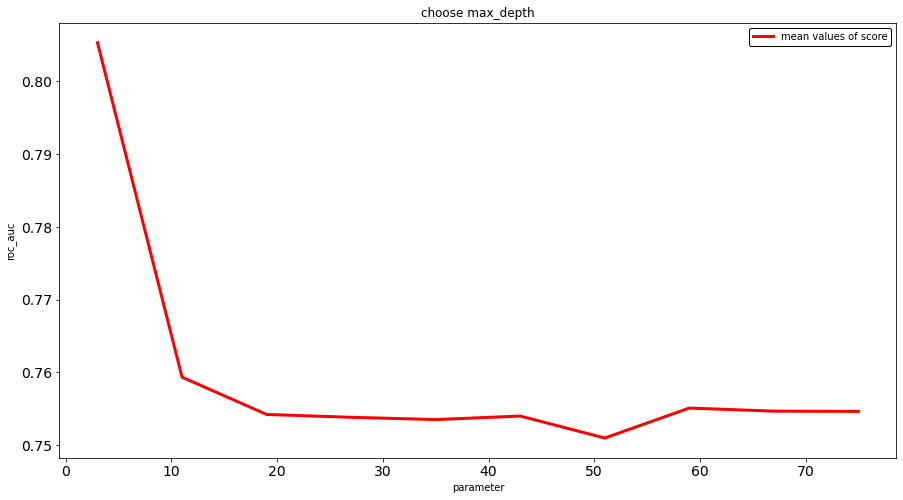

In [35]:
for model, param_name, grid, param_scale in zip(models,# С нормализацией 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train_scaled, y_train, model, param_name, grid, param_scale)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0208s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0562s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1109s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.4s finished


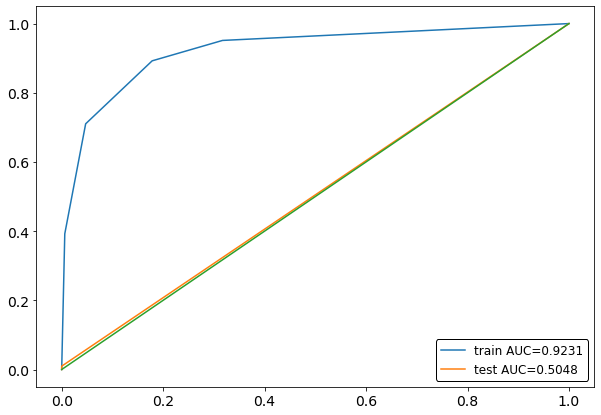

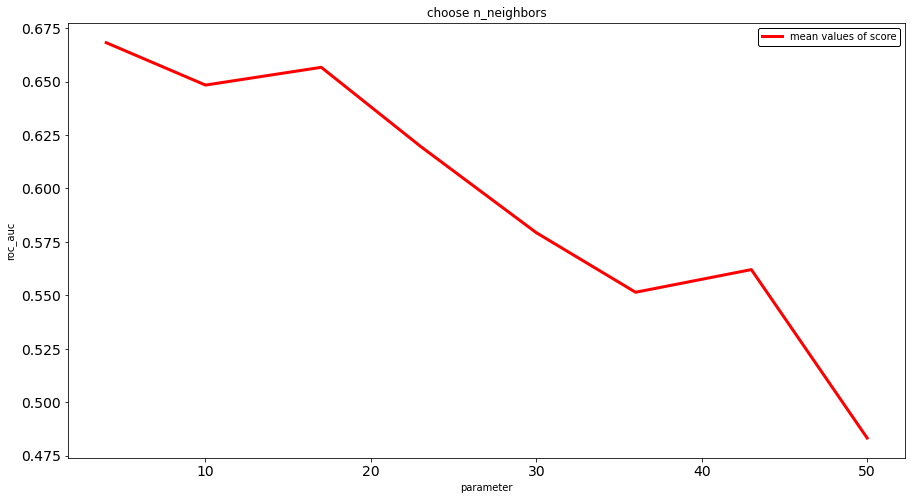

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0207s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0392s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1420s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


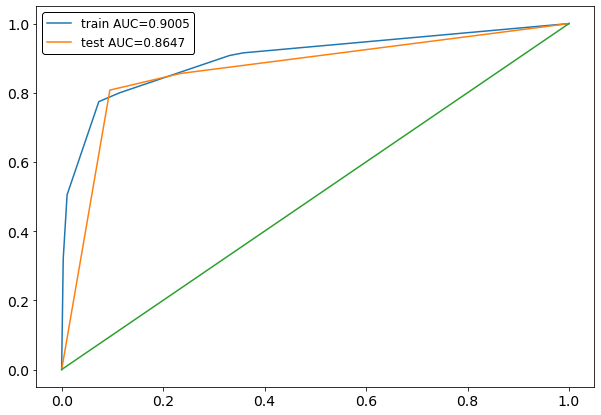

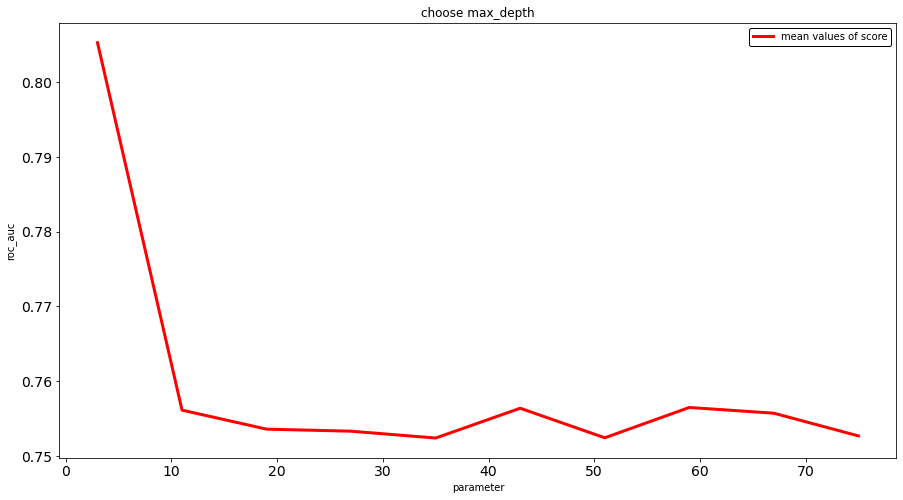

In [36]:
for model, param_name, grid, param_scale in zip(models,# Без нормализации
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)

### Попробуем Random Forest


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [38]:
max_trees = 200

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=42)

global_scores = []

for train_indices, val_indices in tqdm(kf.split(X_train), total=5):
    scores = []
    
    X_train_kf = X_train_scaled[train_indices]
    y_train_kf = y_train[train_indices]
    
    X_val_kf = X_train[val_indices]
    y_val_kf = y_train[val_indices]
    
    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_
    
    for number_of_trees in tqdm(values, leave=False):
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)
        
        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]

        scores.append(roc_auc_score(y_val_kf, thinned_forest.predict_proba(X_val_kf)[:, 1]))
    
    scores = np.array(scores)
    
    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

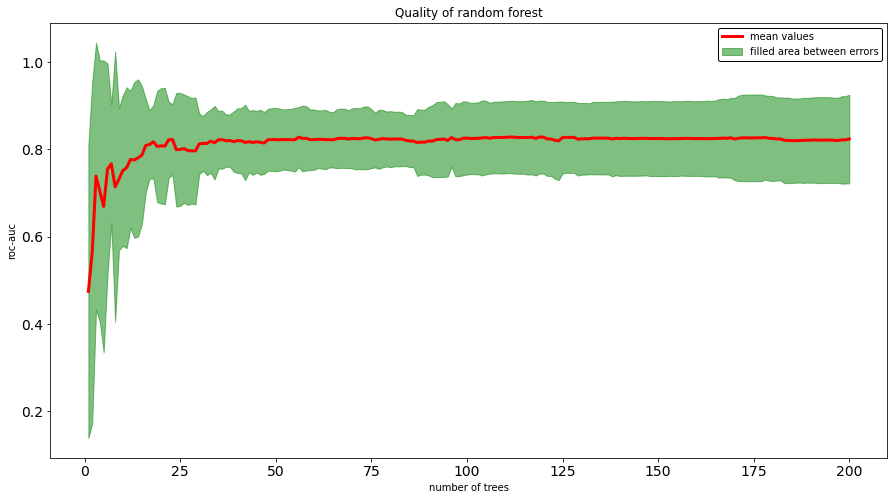

In [39]:
mean_cross_val_score = global_scores.mean(axis=0)
std_cross_val_score = global_scores.std(axis=0)

plt.figure(figsize=(15,8))
plt.title('Quality of random forest')

plt.plot(values, mean_cross_val_score, label='mean values', color='red', lw=3)
plt.fill_between(values, 
                 mean_cross_val_score - 2 * std_cross_val_score, 
                 mean_cross_val_score + 2 * std_cross_val_score, 
                 color='green', 
                 label='filled area between errors',
                 alpha=0.5)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.xlabel('number of trees')
plt.ylabel('roc-auc')

plt.show()

In [40]:
model = RandomForestClassifier(n_estimators=115, n_jobs=-1)

model.fit(X_train, y_train)
y_train_predicted = model.predict_proba(X_train)[:, 1]
y_test_predicted = model.predict_proba(X_test)[:, 1]

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve

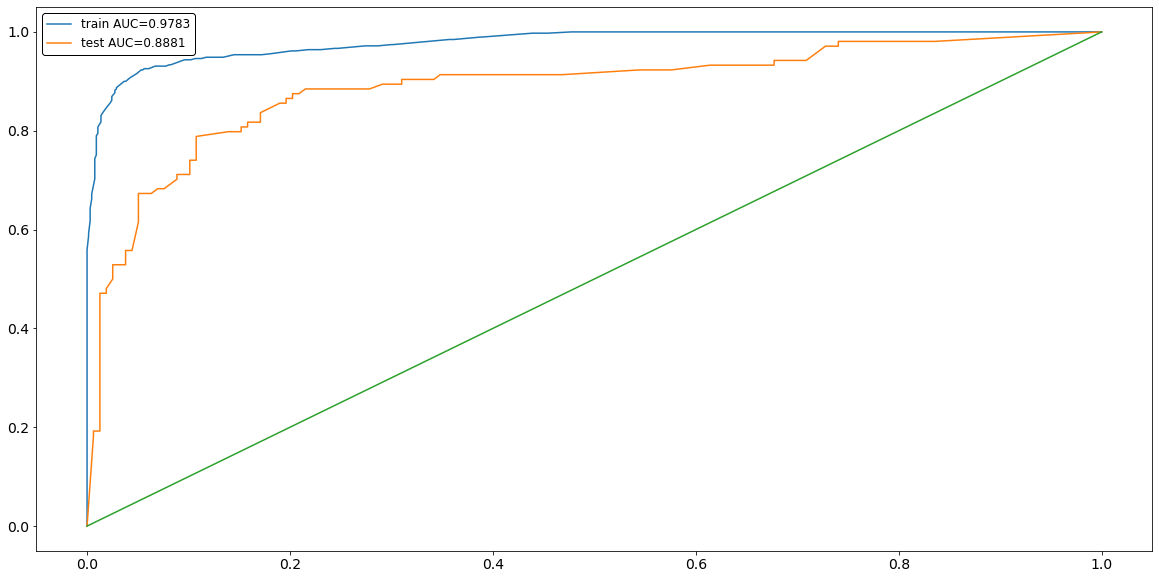

In [42]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

### Попробуем стекинг моделей

In [43]:
from sklearn.model_selection import cross_val_predict

In [44]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]
    
    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)[:, 1]

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [46]:
models = []
models.append(KNeighborsClassifier(n_jobs=-1, n_neighbors=11))
models.append(LogisticRegression())
models.append(RandomForestClassifier(max_depth=3, n_estimators=115, n_jobs=-1))
models.append(RandomForestClassifier(max_depth=7, n_estimators=115, n_jobs=-1))
models.append(DecisionTreeClassifier(max_depth=8))

In [47]:
meta_features_train = np.zeros((X_train.shape[0], 0))
meta_features_test = np.zeros((X_test.shape[0], 0))

In [48]:
for model in tqdm(models):
    train, test = compute_meta_feature(model, X_train, X_test, y_train, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [49]:
stacking_model = LogisticRegression()
stacking_model.fit(meta_features_train, y_train)

y_train_predicted = stacking_model.predict_proba(meta_features_train)[:, 1]
y_test_predicted = stacking_model.predict_proba(meta_features_test)[:, 1]

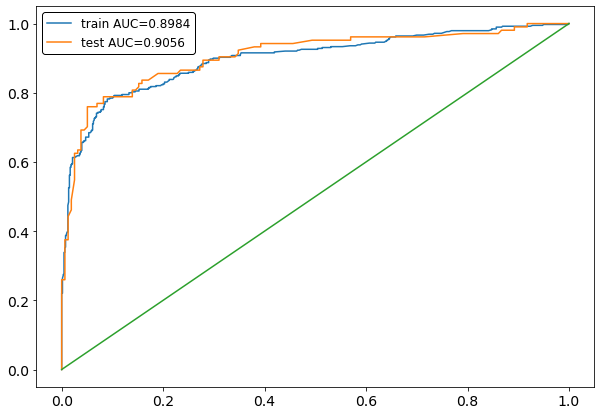

In [50]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

### Попробуем  бустинг

#### XG boost

In [51]:
import xgboost

In [52]:
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

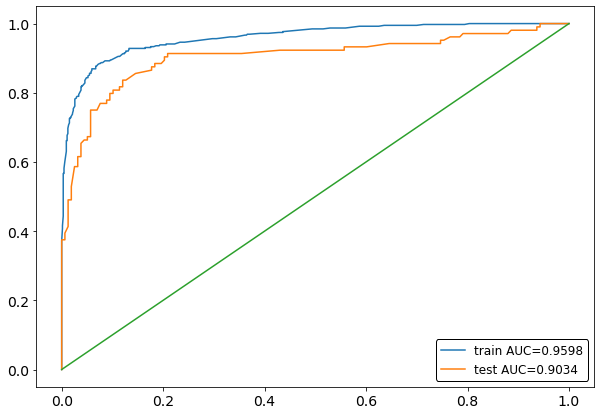

In [53]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

#### CAT BOOST (Загруженный результат)

In [54]:
pip install catboost

     |████████████████████████████████| 76.4 MB 21 kB/s 


In [55]:
import catboost

Самое время вспомнить про наш датасет без One-hot encoding-а

In [56]:
passengers_for_cat_boost = passengers_for_cat_boost.dropna(axis=0, how='any')
X = passengers_for_cat_boost.drop(['Survived'], axis=1)
y = passengers_for_cat_boost['Survived']

In [57]:
X_train_origin, X_test_origin, y_train, y_test = train_test_split(X.values, y.values, 
                                                       train_size=0.8, 
                                                       random_state=42)

In [58]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, cat_features=[1, 5])

boosting_model.fit(X_train_origin, y_train)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

Learning rate set to 0.045907
0:	learn: 0.6565965	total: 51.3ms	remaining: 10.2s
1:	learn: 0.6255207	total: 54.4ms	remaining: 5.38s
2:	learn: 0.5963501	total: 57ms	remaining: 3.75s
3:	learn: 0.5722539	total: 59.3ms	remaining: 2.91s
4:	learn: 0.5469196	total: 61.8ms	remaining: 2.41s
5:	learn: 0.5288040	total: 63.5ms	remaining: 2.05s
6:	learn: 0.5104634	total: 65.8ms	remaining: 1.81s
7:	learn: 0.4982790	total: 67.2ms	remaining: 1.61s
8:	learn: 0.4833556	total: 69.1ms	remaining: 1.47s
9:	learn: 0.4714063	total: 71.3ms	remaining: 1.35s
10:	learn: 0.4596370	total: 73.5ms	remaining: 1.26s
11:	learn: 0.4522765	total: 74.7ms	remaining: 1.17s
12:	learn: 0.4414655	total: 76.8ms	remaining: 1.1s
13:	learn: 0.4327899	total: 79ms	remaining: 1.05s
14:	learn: 0.4254228	total: 80.7ms	remaining: 995ms
15:	learn: 0.4192958	total: 82.7ms	remaining: 951ms
16:	learn: 0.4128885	total: 85ms	remaining: 915ms
17:	learn: 0.4092153	total: 86.5ms	remaining: 875ms
18:	learn: 0.4035954	total: 88.7ms	remaining: 845ms

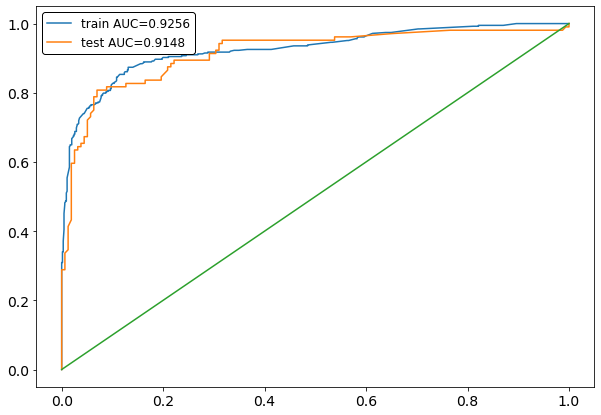

In [59]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve

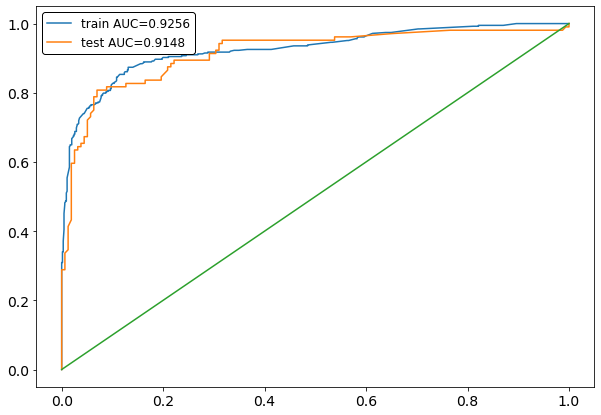

In [61]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

#### Предсказание и выгрузка лучшего результата

In [83]:
test= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic_data/test.csv')
answer = pd.DataFrame()
answer['PassengerId'] = test['PassengerId']
test = test.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'Age'] , axis = 1)

In [86]:

test_val = test.values
prediction = boosting_model.predict(test_val)
prediction

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [87]:
answer['Survived'] = prediction

In [89]:
answer.to_csv(r'/content/drive/MyDrive/Colab Notebooks/to_send_Stepik_kaggle.csv', index=False) 